In [173]:
import numpy as np
import pandas as pd

In [174]:
import torch
from torch import nn

In [175]:
stdev = 3

# NL, SE1, ES
country = 'NL'


df = pd.read_csv(f'{country}_DA_price_v_actual_load_stdev_{stdev}.csv', index_col=0)
old_df = df.copy()
df = df.drop(df[df['DA Price'] <= 0].index)

train_len = int(len(df)*0.7)
train_df = df[:train_len]
train_df = train_df[['hour', 'day', 'month', 'DA Price', 'MW Load']]

test_df = df.copy()

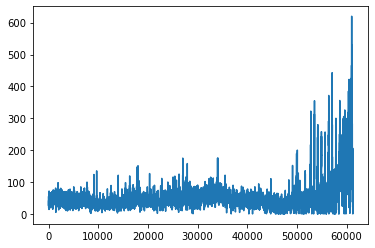

In [192]:
import matplotlib.pyplot as plt

plt.plot(df['DA Price'])

In [176]:
test_df = test_df[:-(len(test_df)%24)]
test_df = test_df[['hour', 'day', 'month', 'DA Price', 'MW Load']]

In [177]:
x_test_arr = np.array([test_df[['hour', 'day', 'month','DA Price']]])
x_test = torch.tensor(x_test_arr).to(device='cpu')

x_test = x_test.reshape((-1, 24, 4))

y_test_arr = np.array([test_df[['MW Load']]])
y_test = torch.tensor(y_test_arr).to(device='cpu').flatten()

In [178]:
PATH = 'FINAL_RESULTS/models/NL_3stdev_50000epochs_0.005lr_0pm_0.5ps_0.5dropoutkl_2400bs_7hn_3stdev.pth'
PATH = 'FINAL_RESULTS/models/ES_3stdev_50000epochs_0.005lr_0pm_0.5ps_0.5dropoutkl_2400bs_7hn_3stdev.pth'
PATH = 'FINAL_RESULTS/models/SE1_3stdev_2000epochs_0.01lr_0pm_0.5ps_0.5dropoutkl_2400bs_7hn_3stdev.pth'

#
PATH = 'FINAL_RESULTS/models/NL_3stdev_5000epochs_0.01lr_0pm_0.5ps_0.5dropoutkl_2400bs_7hn_3stdev.pth'

PATH = 'FINAL_RESULTS/models/NL_3stdev_7000epochs_0.008lr_0pm_0.5ps_0.5dropoutkl_2400bs_7hn_3stdev.pth'

model = torch.load(PATH)
model.cpu()
model.eval()
print(model)

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.5, in_features=4, out_features=4, bias=True)
  (1): ReLU()
  (2): BayesLinear(prior_mu=0, prior_sigma=0.5, in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): BayesLinear(prior_mu=0, prior_sigma=0.5, in_features=4, out_features=4, bias=True)
  (5): ReLU()
  (6): BayesLinear(prior_mu=0, prior_sigma=0.5, in_features=4, out_features=4, bias=True)
  (7): ReLU()
  (8): BayesLinear(prior_mu=0, prior_sigma=0.5, in_features=4, out_features=4, bias=True)
  (9): Dropout(p=0.5, inplace=True)
  (10): BayesLinear(prior_mu=0, prior_sigma=0.5, in_features=4, out_features=4, bias=True)
  (11): ReLU()
  (12): BayesLinear(prior_mu=0, prior_sigma=0.5, in_features=4, out_features=4, bias=True)
  (13): ReLU()
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): BayesLinear(prior_mu=0, prior_sigma=0.5, in_features=96, out_features=48, bias=True)
  (16): ReLU()
  (17): BayesLinear(prior_mu=0, prior_sigma=0.5, in_features=48, out_features=24, bia

In [179]:
def MAPELoss(output, target):
    return torch.mean(torch.abs((target - output) / target))

In [180]:
y_pred = model(x_test).flatten()
mape_loss = MAPELoss(y_pred, y_test)
print(f'Pytorch MAPE loss ES {mape_loss}')


Pytorch MAPE loss ES 0.12849142540133918


In [181]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

In [182]:
new_model = tf.keras.models.load_model('FINAL_RESULTS/TF_model_SE1')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24, 3)             12        
                                                                 
 dense_1 (Dense)             (None, 24, 3)             12        
                                                                 
 dense_2 (Dense)             (None, 24, 3)             12        
                                                                 
 dense_3 (Dense)             (None, 24, 3)             12        
                                                                 
 dense_4 (Dense)             (None, 24, 3)             12        
                                                                 
 flatten (Flatten)           (None, 72)                0         
                                                                 
 dense_5 (Dense)             (None, 36)                2

In [183]:
x_test = test_df[['hour', 'day', 'DA Price']]
print(x_test)
x_test = x_test.to_numpy()
x_test = x_test.reshape((-1, 24, 3))
y_pred_tf = new_model.predict(x_test)
y_pred_tf = y_pred_tf.flatten()
mape_loss_tf = MAPELoss(y_pred_tf, y_test)

       hour  day  DA Price
0         0    4     39.89
1         1    4     33.26
2         2    4     29.15
3         3    4     25.63
4         4    4     25.78
...     ...  ...       ...
61245    23    3     55.65
61246     0    4      5.71
61247     1    4     26.15
61248     2    4     25.12
61251     5    4      0.04

[61056 rows x 3 columns]


In [184]:
print(f'Pytorch MAPE loss: {mape_loss}')
print(f'Tensorflow reference MAPE loss: {mape_loss_tf}')

Pytorch MAPE loss: 0.12849142540133918
Tensorflow reference MAPE loss: 0.9783254684016468


In [185]:
import pandas as pd
NL_FNN_labels = pd.read_csv('FINAL_RESULTS/FNN_reference_model_NL/labels.csv')['MW.Load']
NL_FNN_preds = pd.read_csv('FINAL_RESULTS/FNN_reference_model_NL/prediction.csv')['predict_class']
NL_FNN_vals = pd.read_csv('FINAL_RESULTS/FNN_reference_model_NL/x_vals.csv')['DA.Price']

In [186]:
ES_FNN_labels = pd.read_csv('FINAL_RESULTS/FNN_reference_model_ES/labels.csv')['MW.Load']
ES_FNN_preds = pd.read_csv('FINAL_RESULTS/FNN_reference_model_ES/prediction.csv')['predict_class']
ES_FNN_vals = pd.read_csv('FINAL_RESULTS/FNN_reference_model_ES/x_vals.csv')['DA.Price']


In [187]:
SE_FNN_labels = pd.read_csv('FINAL_RESULTS/FNN_reference_model_SE/labels.csv')['MW.Load']
SE_FNN_preds = pd.read_csv('FINAL_RESULTS/FNN_reference_model_SE/prediction.csv')['predict_class']
SE_FNN_vals = pd.read_csv('FINAL_RESULTS/FNN_reference_model_SE/x_vals.csv')['DA.Price']


In [188]:
def MAPELoss2(output, target):
    return np.mean(np.abs((target - output) / target))


In [189]:
fnn_nl_mape = MAPELoss2(NL_FNN_preds, NL_FNN_labels)
fnn_es_mape = MAPELoss2(ES_FNN_preds, ES_FNN_labels)
fnn_se_mape = MAPELoss2(SE_FNN_preds, SE_FNN_labels)


In [190]:
print(fnn_nl_mape)
print(fnn_es_mape)
print(fnn_se_mape)


0.13611174131678744
0.12175456179623251
0.15503383292519657
